In [55]:
# Import Python libraries
# This code uses python v3.12.0, tifffile v2023.9.26, matplotlib v3.8.2
import tifffile
import matplotlib.pyplot as plt

fullres_multich_img = tifffile.imread(
"D:\Alexis\Projects\SpatialOmics_cellpose\data_DRG\output-XETG00245__0058080__Test_Lesion_DRGs_1__20250806__180812\morphology_focus\morphology_focus_0003.ome.tif", is_ome=True, level=0, aszarr=False)


<tifffile.TiffFile 'morphology_focus_0003.ome.tif'> OME series cannot read multi-file pyramids


In [56]:
import os
import tifffile
import numpy as np
from PIL import Image

def crop_and_save_images(fullres_img,  x, y, width, height, output_folder):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Crop the full-resolution image
    cropped_fullres = fullres_img[:, y:y+height, x:x+width]
    
    # Save the cropped full-resolution image
    tifffile.imwrite(os.path.join(output_folder, f'C3_cropped_polygon_x{x}_y{y}_width{width}.tif'), cropped_fullres)
    
    print(f"Cropped images saved in {output_folder} with coordinates x{x}_y{y}_width_{width}")



In [ ]:

def divide(a, b):
    if b == 0:
        return "Error: Division by zero is not allowed."
    else:
        return int(a / b)  # Convert the result to an integer

# usage:
output_folder = r"D:\Alexis\Projects\SpatialOmics_cellpose\cropped_images"
start_x = 3850 
start_y = 1594

width, height = 2048, 2048
width, height = 1024, 1024

# Rescale factor for Xenium output first layer (highest resolution) is 0.2125
x = divide(start_x, 0.2125)
y = divide(start_y, 0.2125)

print("x =", x)
print("y =", y)

crop_and_save_images(fullres_multich_img, x, y, width, height, output_folder)

x = 18117
y = 7501
Cropped images saved in D:\Alexis\Projects\SpatialOmics_cellpose\cropped_images with coordinates x18117_y7501_width_1024


In [64]:
# Import Python libraries
# This script was tested with zarr v2.13.6
import zarr
import numpy as np

# Function to open a Zarr file
def open_zarr(path: str) -> zarr.Group:
    store = (zarr.ZipStore(path, mode="r")
    if path.endswith(".zip")
    else zarr.DirectoryStore(path)
    )
    return zarr.group(store=store)

root = open_zarr("D:\Alexis\Projects\SpatialOmics_cellpose\data_DRG\output-XETG00245__0058080__Test_Lesion_DRGs_1__20250806__180812\cells.zarr.zip")
# Create cell and nucleus segmentation mask np array objects to read or modify
cellseg_mask = np.array(root["masks"][1])
nucseg_mask = np.array(root["masks"][0])
polygon_sets = root["polygon_sets"]



In [65]:
def print_zarr_contents(group, indent=""):
    for key, value in group.items():
        print(f"{indent}{key}:")
        if isinstance(value, zarr.Group):
            print_zarr_contents(value, indent + "  ")
        elif isinstance(value, zarr.Array):
            print(f"{indent}  Shape: {value.shape}")
            print(f"{indent}  Dtype: {value.dtype}")
            print(f"{indent}  Chunks: {value.chunks}")
            if value.shape[0] < 10:  # Print small arrays entirely
                print(f"{indent}  Data: {value[:]}")
            else:  # Print first and last 5 elements for larger arrays
                print(f"{indent}  First 5 elements: {value[:5]}")
                print(f"{indent}  Last 5 elements: {value[-5:]}")

# Now call this function with root object
print_zarr_contents(root)

cell_id:
  Shape: (19156, 2)
  Dtype: uint32
  Chunks: (19156, 2)
  First 5 elements: [[349670      1]
 [428413      1]
 [631325      1]
 [634696      1]
 [949962      1]]
  Last 5 elements: [[3895087380          1]
 [3895135588          1]
 [3895680488          1]
 [3895837645          1]
 [3895889732          1]]
cell_summary:
  Shape: (19156, 8)
  Dtype: float64
  Chunks: (19156, 1)
  First 5 elements: [[8.64560486e+02 1.76496448e+03 4.12141109e+02 8.63527527e+02
  1.76367139e+03 8.63839094e+01 0.00000000e+00 1.00000000e+00]
 [8.21694153e+02 1.88567542e+03 7.35595339e+01 8.21739014e+02
  1.88564905e+03 3.82925014e+01 0.00000000e+00 1.00000000e+00]
 [8.55230164e+02 1.80879443e+03 5.37359395e+01 8.55658203e+02
  1.80878796e+03 3.35059387e+01 0.00000000e+00 1.00000000e+00]
 [8.62698730e+02 1.80782092e+03 6.18189085e+01 8.62441284e+02
  1.80784753e+03 3.92859389e+01 0.00000000e+00 1.00000000e+00]
 [1.03095361e+03 2.27411328e+03 3.99271577e+02 1.02601099e+03
  2.27862476e+03 3.17448449e+

In [22]:
3033*0.2125

644.5124999999999

In [23]:
3468*0.2125

736.9499999999999

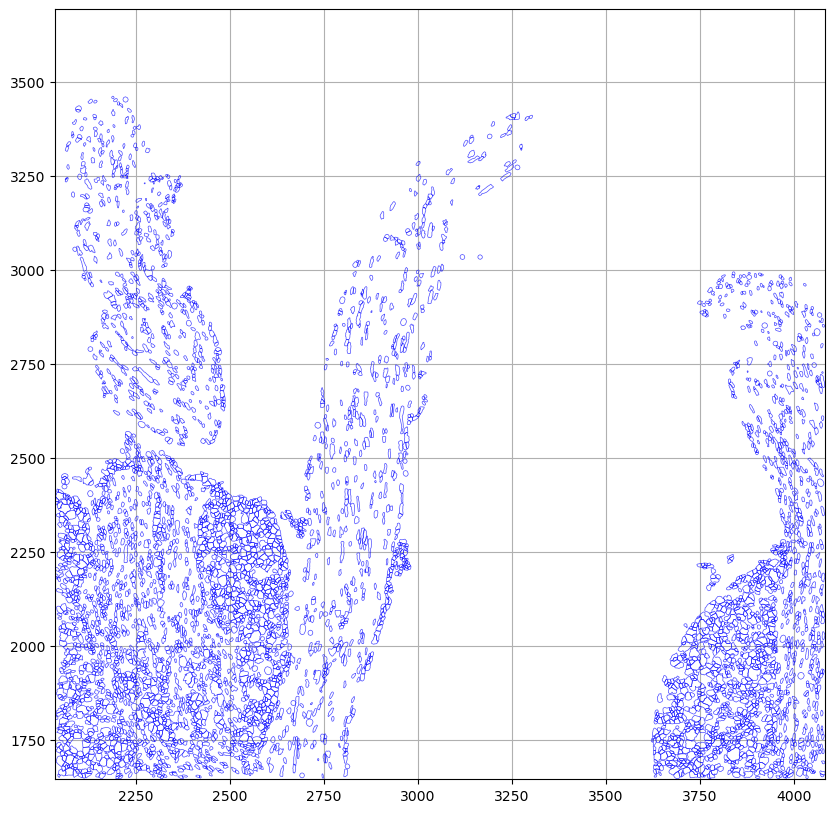

In [66]:
# Show the plot of select region of polygons
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Access the polygon set (replace '1' with '0' if needed)
polygon_set = root['polygon_sets']['1']

# Load data arrays
num_vertices = polygon_set['num_vertices'][:]
vertices = polygon_set['vertices'][:]

start_x = 2036
start_y = 1645

# Define the cropping region
x_min, x_max = start_x, start_x + 2048  # Adjust these values based on your dataset
y_min, y_max = start_y, start_y + 2048  # Adjust these values based on your dataset

# Collect polygons without flipping
all_polygons = []

for i in range(len(num_vertices)):
    n_vertices = num_vertices[i]
    if n_vertices < 3:
        continue  # Skip if not enough vertices to form a polygon

    # Extract x and y coordinates
    vertex_row = vertices[i, :2 * n_vertices]
    x_coords = vertex_row[::2]
    y_coords = vertex_row[1::2]

    # Check if the polygon is within the crop bounds
    if (x_coords.min() >= x_min and x_coords.max() <= x_max and
        y_coords.min() >= y_min and y_coords.max() <= y_max):
        
        # Close the polygon by appending the first point to the end
        x_coords = np.append(x_coords, x_coords[0])
        y_coords = np.append(y_coords, y_coords[0])

        # Combine x and y into coordinates
        polygon_coords = np.column_stack((x_coords, y_coords))
        all_polygons.append(polygon_coords)

# Create a LineCollection for efficient plotting
line_collection = LineCollection(all_polygons, linewidths=0.5, colors='blue', alpha=0.7)

# Plot all polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Set equal aspect ratio to ensure the coordinate system looks square
ax.set_aspect('equal')

# Add grid for better visibility
ax.grid(True)

# Add the polygon collection to the plot
ax.add_collection(line_collection)

# Set the x and y limits to crop the plot
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])

# Show the plot
plt.show()

In [68]:

# Scaling factors to map the original (x_min, x_max) and (y_min, y_max) to 0-800
scale_x = 2048 / (x_max - x_min)
scale_y = 2048 / (y_max - y_min)

# New list to store the scaled polygons
scaled_all_polygons = []

# Iterate over all polygons and apply the scaling transformation
for polygon_coords in all_polygons:
    # Separate x and y coordinates
    x_coords = polygon_coords[:, 0]
    y_coords = polygon_coords[:, 1]
    
    # Apply the scaling transformation to map coordinates to [0, 800]
    x_coords_scaled = ((x_coords - x_min) * scale_x)
    y_coords_scaled = ((y_coords - y_min) * scale_y)
    
    # Combine scaled x and y coordinates back into a single array
    scaled_polygon_coords = np.column_stack((x_coords_scaled, y_coords_scaled))
    
    # Append the scaled polygon to the new list
    scaled_all_polygons.append(scaled_polygon_coords)

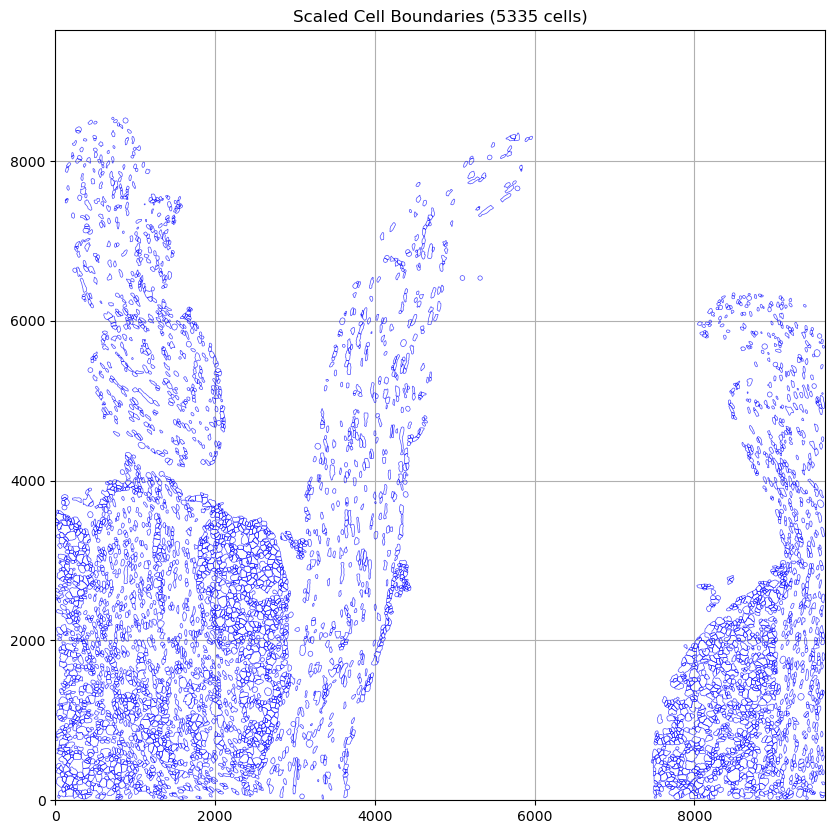

Original bounds: x=[2036.00, 4084.00], y=[1645.00, 3693.00]
Scaling factors: x=4.7059, y=4.7059
Scaled 5335 polygons to fit in a 200x200 square


In [70]:
# Scaling factors to map the original (x_min, x_max) and (y_min, y_max) to 0-800
scale_x = 2048/0.2125 / (x_max - x_min)
scale_y = 2048/0.2125 / (y_max - y_min)

# New list to store the scaled polygons
scaled_all_polygons = []

# Iterate over all polygons and apply the scaling transformation
for polygon_coords in all_polygons:
    # Separate x and y coordinates
    x_coords = polygon_coords[:, 0]
    y_coords = polygon_coords[:, 1]
    
    # Apply the scaling transformation to map coordinates to [0, 800]
    x_coords_scaled = ((x_coords - x_min) * scale_x)
    y_coords_scaled = ((y_coords - y_min) * scale_y)
    
    # Combine scaled x and y coordinates back into a single array
    scaled_polygon_coords = np.column_stack((x_coords_scaled, y_coords_scaled))
    
    # Append the scaled polygon to the new list
    scaled_all_polygons.append(scaled_polygon_coords)

# Plot the scaled polygons
plt.figure(figsize=(10, 10))

# Create a LineCollection for efficient plotting of scaled polygons
scaled_line_collection = LineCollection(scaled_all_polygons, linewidths=0.5, colors='blue', alpha=0.7)

# Add the scaled polygon collection to the plot
plt.gca().add_collection(scaled_line_collection)

# Set equal aspect ratio
plt.gca().set_aspect('equal')

# Add grid for better visibility
plt.grid(True)

# Set the limits for the scaled plot (0-200 range)
plt.xlim([0, 2048/0.2125])
plt.ylim([0, 2048/0.2125])

# Add title
plt.title(f"Scaled Cell Boundaries ({len(scaled_all_polygons)} cells)")

# Show the plot
plt.show()

# Print scaling information
print(f"Original bounds: x=[{x_min:.2f}, {x_max:.2f}], y=[{y_min:.2f}, {y_max:.2f}]")
print(f"Scaling factors: x={scale_x:.4f}, y={scale_y:.4f}")
print(f"Scaled {len(scaled_all_polygons)} polygons to fit in a 200x200 square")

In [30]:
import numpy as np
dat = np.load(r"G:/Alexis_data/ST/Calculation_5k/Manual_cropped_square_com_6_seg.npy",
              allow_pickle=True)

# Cellpose GUI / CLI export? -> a dict with many fields
if isinstance(dat.item(), dict):          # .item() stops NumPy’s warning
    masks = dat.item()['masks']           # label image (0 = background)
    img   = dat.item().get('img', None)   # original image not always saved
else:                                     # “bare” array of labels
    masks = dat
    img   = None


In [33]:
from cellpose import utils    # `pip install cellpose` if needed

outlines = utils.outlines_list(masks)  # returns a list of N×2 XY arrays


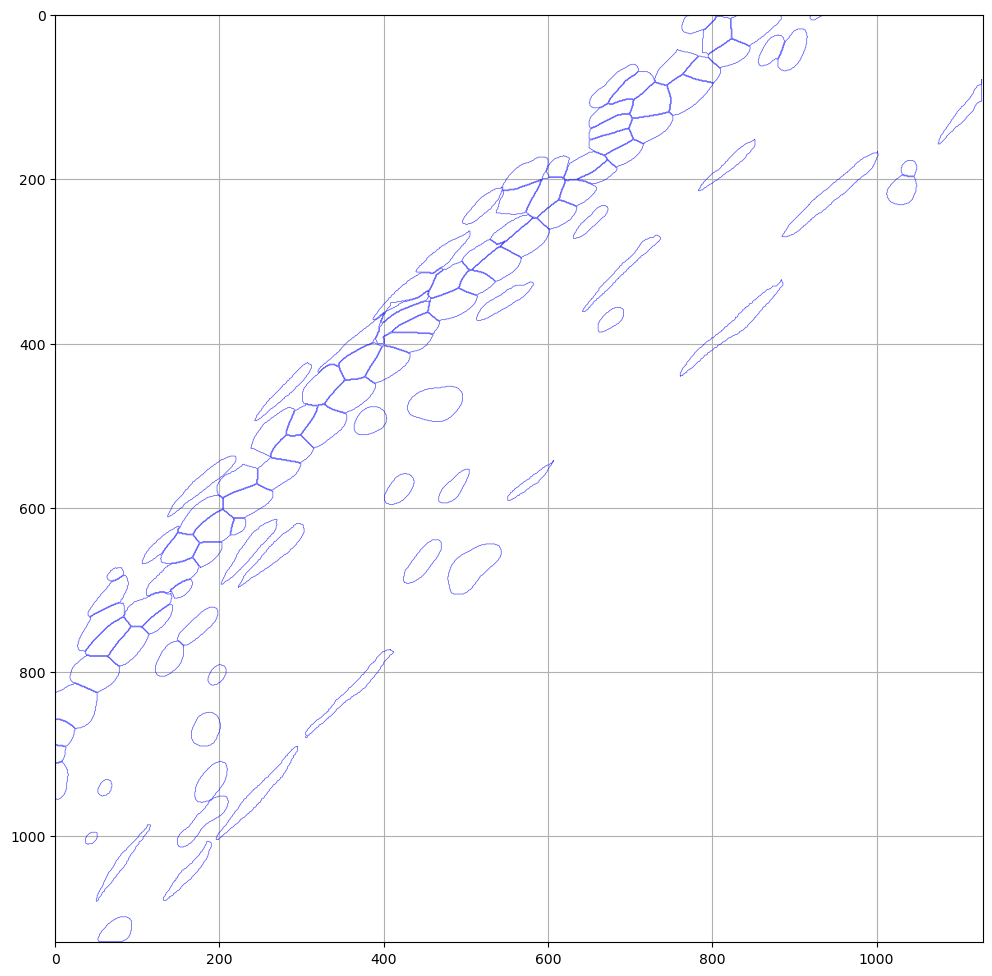

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from cellpose import utils                                   # pip install cellpose

# ---------- 1. load masks (+ image if present) ------------
dat   = np.load(r"G:/Alexis_data/ST/Calculation_5k/Manual_cropped_square_com_6_seg.npy",
                allow_pickle=True)
masks = dat.item()['masks'] if isinstance(dat.item(), dict) else dat

# ---------- 2. outlines -----------------------------------
outlines = utils.outlines_list(masks)
polys    = [np.vstack([o, o[0]]) for o in outlines]          # close each loop

# ---------- 3. LineCollection -----------------------------
lc = LineCollection(polys, colors='blue', linewidths=0.5, alpha=0.7)

# ---------- 4. plot ---------------------------------------
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')  # white figure
ax.set_facecolor('white')                                    # white axes
ax.set_aspect('equal')
ax.grid(True)

ax.add_collection(lc)

ax.set_xlim(0, masks.shape[1])
ax.set_ylim(masks.shape[0], 0)                               # invert y

plt.tight_layout()
plt.show()


TypeError: Invalid shape (2, 1129, 1129) for image data

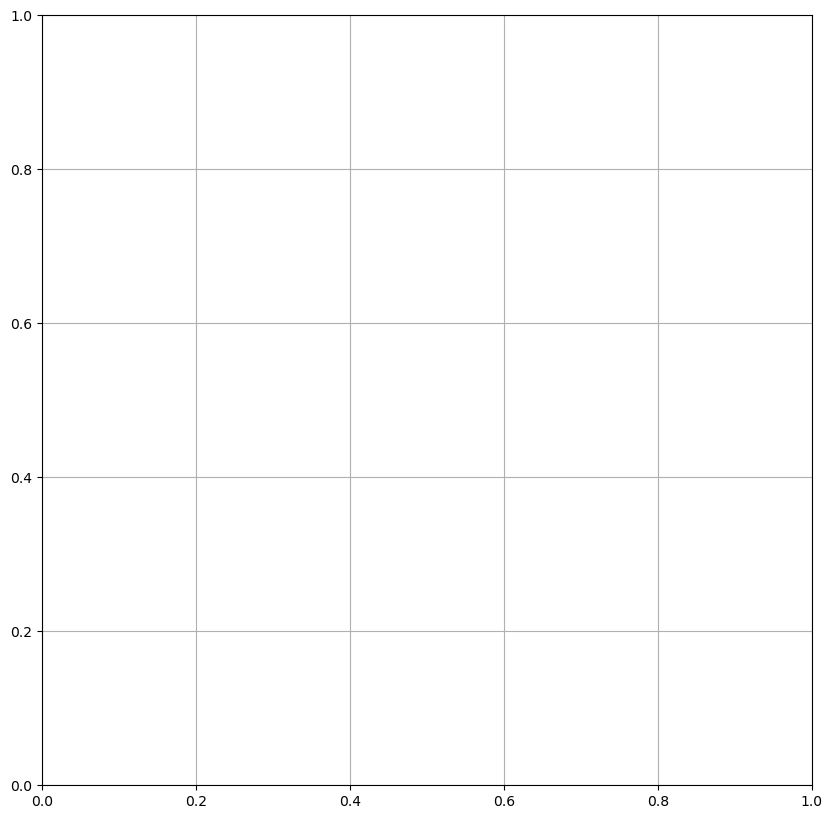

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from cellpose import utils
import tifffile                                     # pip install tifffile

# -------------------------------------------------------------------------
# paths
seg_path = r"G:/Alexis_data/ST/Calculation_5k/Manual_cropped_square_com_6_seg.npy"
tif_path = r"G:/Alexis_data/ST/Calculation_5k/cropped_square_com_6.tif"

# -------------------------------------------------------------------------
# 1) load data
dat   = np.load(seg_path, allow_pickle=True)
masks = dat.item()['masks'] if isinstance(dat.item(), dict) else dat
img   = tifffile.imread(tif_path)

# -------------------------------------------------------------------------
# 2) outlines (in mask pixel units)
SCALE = 1 / 0.2125          # ≈ 4.705882  tif-px per mask-px  (see note below)

outlines = utils.outlines_list(masks)
polys    = [np.vstack([o, o[0]]) * SCALE   # close loop & scale to TIFF space
            for o in outlines]

# -------------------------------------------------------------------------
# 3) build collection
lc = LineCollection(polys, colors='blue', linewidths=0.5, alpha=0.7)

# -------------------------------------------------------------------------
# 4) plot overlay
fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')
ax.set_facecolor('white')
ax.set_aspect('equal')
ax.grid(True)

# show the TIFF
if img.ndim == 2:
    ax.imshow(img, cmap='gray')
else:
    ax.imshow(img)

ax.add_collection(lc)

# full image limits
ax.set_xlim(0, img.shape[1])
ax.set_ylim(img.shape[0], 0)   # flip y so origin is top-left

plt.tight_layout()
plt.show()


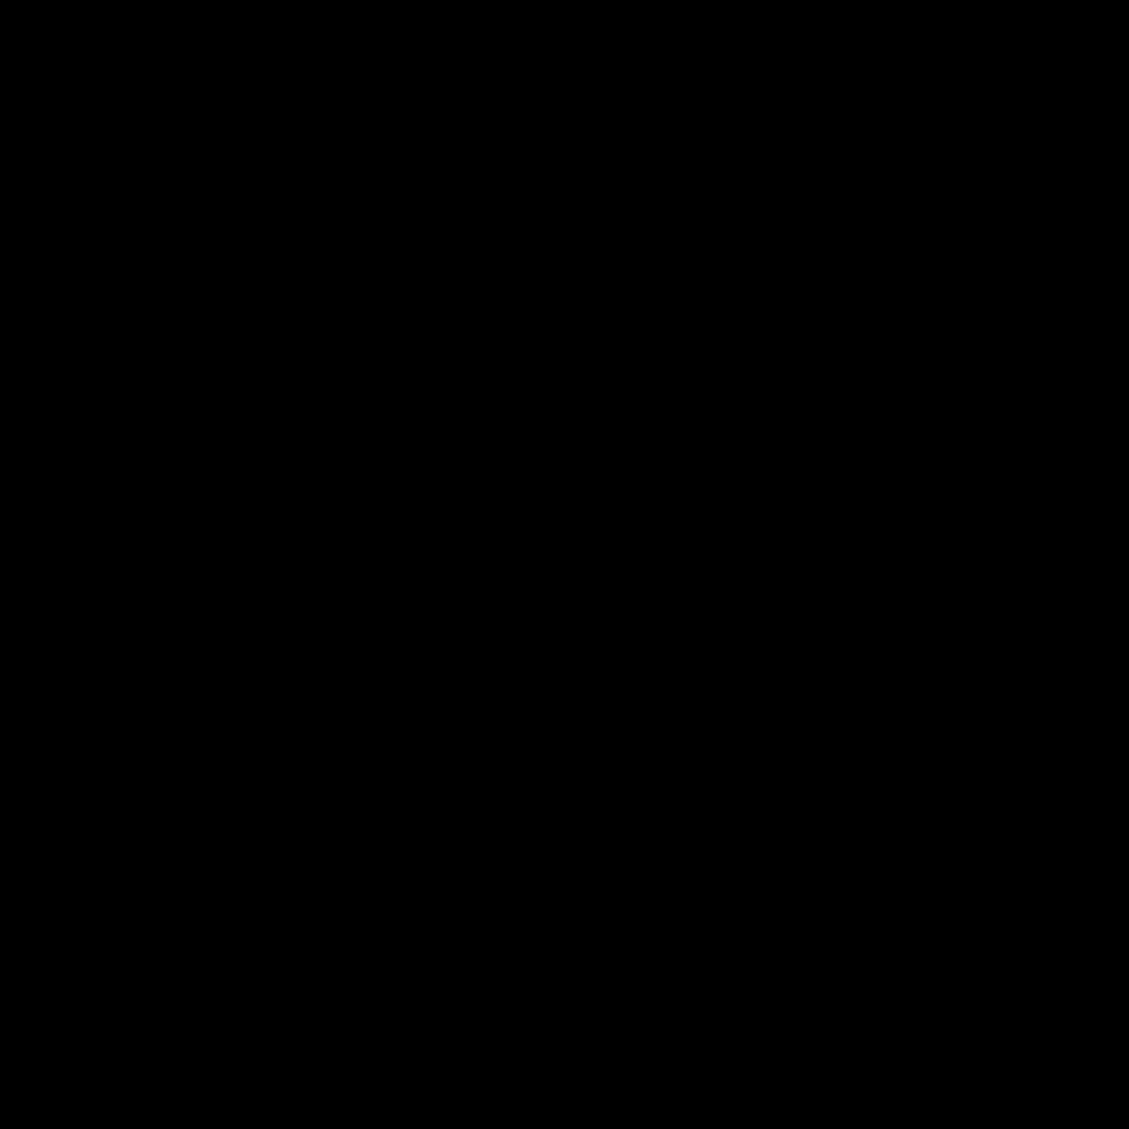

In [54]:
from PIL import Image
mannul_seg_filename = r"G:/Alexis_data/ST/Calculation_5k/Manual_cropped_square_com_6_cp_masks.png"

# Open the image using PIL
mannul_seg_image = Image.open(mannul_seg_filename)
mannul_seg_image

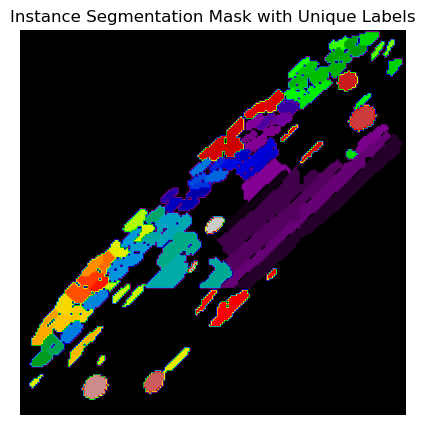

In [52]:
# Iterate over polygons and assign each one a unique label
# Create a blank canvas (e.g., 800x800)
from shapely.geometry import Polygon
from skimage.draw import polygon 
image_array = np.zeros((200, 200), dtype=np.uint8)


for label, poly_coords in enumerate(scaled_all_polygons, start=1):
    # Create a Shapely polygon from the coordinates
    polygon_obj = Polygon(poly_coords)

    # Extract x and y coordinates for drawing
    x_coords, y_coords = poly_coords[:, 0], poly_coords[:, 1]

    # Convert polygon coordinates to pixel coordinates and rasterize
    rr, cc = polygon(y_coords, x_coords, shape=image_array.shape)

    # Assign the unique label to the instance in the image (label 1, 2, 3, ...)
    image_array[rr, cc] = label

# Visualize the result
plt.figure(figsize=(10, 5))
plt.imshow(image_array, cmap='nipy_spectral')
plt.title('Instance Segmentation Mask with Unique Labels')
plt.axis('off')
plt.show()

In [47]:
# Print the number of distinct labels (polygons) assigned
num_cells = label  # The last label is the number of cells
print(f"Number of cells (polygons) detected: {num_cells}")

Number of cells (polygons) detected: 107


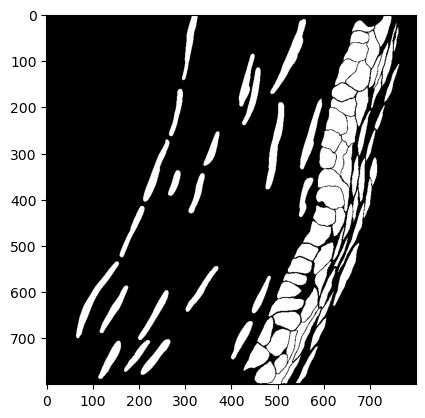

In [24]:
# Get the segmentation mask of groud truth
from PIL import Image
import numpy as np

ground_truth_image = mannul_seg_image  # Convert to grayscale

# Convert the grayscale image to a NumPy array
ground_truth_array = np.array(ground_truth_image)

# Convert the grayscale image to binary by thresholding
threshold = 128  # Adjust threshold value as needed
binary_image = (ground_truth_array > threshold).astype(np.uint8) * 255  # Ensures single channel binary

# Ensure binary_image is single channel (remove any extra dimensions)
if len(binary_image.shape) > 2:
    binary_image = binary_image[:, :, 0]

plt.imshow(binary_image, cmap='gray')

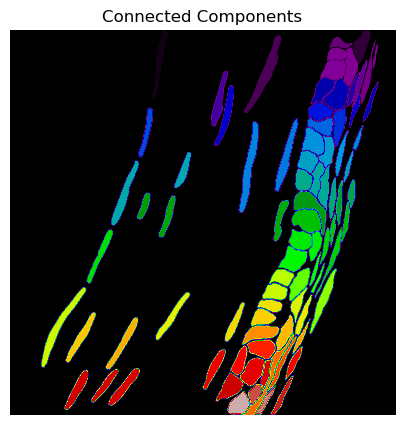

In [25]:
import cv2
# Apply connected components to label the connected regions
# It returns two values:
# num_labels: number of labels (including background)
# labels: image array where each connected component has a unique label
num_labels, labels_im = cv2.connectedComponents(binary_image)

# Visualize the result using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(labels_im, cmap='nipy_spectral')
plt.title('Connected Components')
plt.axis('off')
plt.show()

In [27]:
import numpy as np
import pandas as pd
import cv2
from shapely.geometry import Polygon
from skimage.draw import polygon

def calculate_iou(ground_truth_mask, test_mask):
    # Calculate intersection and union
    intersection = np.logical_and(ground_truth_mask, test_mask)
    union = np.logical_or(ground_truth_mask, test_mask)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    return iou

def calculate_precision(ground_truth_mask, test_mask):
    # Calculate true positives and false positives
    true_positives = np.sum(np.logical_and(test_mask, ground_truth_mask))
    predicted_positives = np.sum(test_mask)
    precision = true_positives / predicted_positives if predicted_positives > 0 else 0
    return precision

def calculate_recall(ground_truth_mask, test_mask):
    # Calculate true positives and false negatives
    true_positives = np.sum(np.logical_and(test_mask, ground_truth_mask))
    actual_positives = np.sum(ground_truth_mask)
    recall = true_positives / actual_positives if actual_positives > 0 else 0
    return recall

ious = []
precisions = []
recalls = []

iou_threshold = 0.5
matched_test_instances = set()  # To track test instances that have been matched
  
comparison_data = []

# Loop over each instance in the ground truth
for label in range(1, num_labels):  # num_labels from connectedComponents
    # Create a binary mask for the current label (instance) in the ground truth
    ground_truth_mask = (labels_im == label).astype(np.uint8)
    
    best_iou = 0  # Track the best IoU for the current ground truth instance
    best_test_label = None  # Track which test label gives the best IoU
    
    print(f"\nProcessing ground truth instance {label}...")
    
    # Loop over the test set polygons (each one is already labeled in your test set)
    for test_label, poly_coords in enumerate(scaled_all_polygons, start=1):
        if test_label in matched_test_instances:
            # Skip this test instance if it has already been matched
            continue
        
        # Create binary mask for the current test set polygon (instance)
        test_mask = np.zeros_like(ground_truth_mask)
        x_coords, y_coords = poly_coords[:, 0], poly_coords[:, 1]
        rr, cc = polygon(y_coords, x_coords, shape=test_mask.shape)
        test_mask[rr, cc] = 1
        
        # Calculate IoU between the current ground truth instance and test set instance
        iou = calculate_iou(ground_truth_mask, test_mask)



        # Print IoU to monitor progress
        print(f"  IoU between ground truth {label} and test {test_label}: {iou:.4f}")
        
        # If IoU is above the threshold and better than the current best, record it
        if iou > iou_threshold and iou > best_iou:
            best_iou = iou
            best_test_label = test_label

            precision = calculate_precision(ground_truth_mask, test_mask)
            recall = calculate_recall(ground_truth_mask, test_mask)

    # If we found a match (IoU > 0.50), append it to the list
    if best_test_label is not None:
        print(f"  Best match for ground truth {label} is test {best_test_label} with IoU {best_iou:.4f}")
        matched_test_instances.add(best_test_label)
        ious.append(best_iou)
        precisions.append(precision)
        recalls.append(recall)

        # Append the comparison data
        comparison_data.append({
            'Ground Truth Instance': label,
            'Xenium Segmentation Instance': best_test_label,
            'IoU': best_iou,
            'Precision': precision,
            'Recall': recall
        })
        
    else:
        print(f"  No match found for ground truth {label} (IoU > {iou_threshold})")

# Save the DataFrame to a CSV file
comparison_df = pd.DataFrame(comparison_data)
comparison_df.to_csv('iou_comparison_results.csv', index=False)

# Display the first few rows of the DataFrame
print(comparison_df.head())

# Calculate mean IoU if we have any matches
if ious:
    mean_iou = np.mean(ious)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    print(f"\nMean IoU across matched instances: {mean_iou:.4f}")
    print(f"Mean Precision across matched instances: {mean_precision:.4f}")
    print(f"Mean Recall across matched instances: {mean_recall:.4f}")
else:
    print("\nNo matched instances found with IoU > 0.50")


Processing ground truth instance 1...
  IoU between ground truth 1 and test 1: 0.0000
  IoU between ground truth 1 and test 2: 0.0000
  IoU between ground truth 1 and test 3: 0.0000
  IoU between ground truth 1 and test 4: 0.0000
  IoU between ground truth 1 and test 5: 0.0000
  IoU between ground truth 1 and test 6: 0.0000
  IoU between ground truth 1 and test 7: 0.0000
  IoU between ground truth 1 and test 8: 0.0000
  IoU between ground truth 1 and test 9: 0.0000
  IoU between ground truth 1 and test 10: 0.0000
  IoU between ground truth 1 and test 11: 0.0000
  IoU between ground truth 1 and test 12: 0.0000
  IoU between ground truth 1 and test 13: 0.0000
  IoU between ground truth 1 and test 14: 0.0000
  IoU between ground truth 1 and test 15: 0.0000
  IoU between ground truth 1 and test 16: 0.0000
  IoU between ground truth 1 and test 17: 0.0000
  IoU between ground truth 1 and test 18: 0.0000
  IoU between ground truth 1 and test 19: 0.0000
  IoU between ground truth 1 and test 2

In [28]:
comparison_df

,Ground Truth Instance,Xenium Segmentation Instance,IoU,Precision,Recall
0,2,61,0.720207,0.919008,0.769018
1,8,56,0.630685,0.837359,0.718728
2,9,16,0.741119,0.752099,0.980683
3,13,22,0.633352,0.781163,0.769966
4,14,24,0.592575,0.962877,0.606430
5,18,18,0.780339,0.929725,0.829251
6,21,21,0.628895,0.638849,0.975824
7,25,20,0.587279,0.630262,0.895957
8,34,15,0.737517,0.841416,0.856583
9,35,68,0.528355,0.660757,0.725032
